# Выявление закономерностей определяющих успешность игры

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры, организации нужно выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Из открытых источников доступны исторические данные по 2016 год.

Анализ данных будет проведен в несколько этапов:
* Изучение данных
* Предобработка данных
* Анализ данных
* Изучение пользователей каждого региона
* Проверка гипотез
* Общий вывод

## Изучение данных

Импортируем все необходимые в дальнешей работе библиотеки в следующей ячейке:

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levene
from scipy import stats as st

Прочтем файл взятый для анализа:

In [115]:
df = pd.read_csv('/datasets/games.csv')
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


При первом взгляде на датасет можно заметить, что название столбцов нужно привести к одному регистру, поменять тип данных в столбце Year_of_Release и заполнить пропусти. Так же возможно часть данных придется убрать, так как они предоставлены за всю историю, но какое-то время индустрия находилась в зачатке и было много провальных платформ, которые из за небольшого распространения ограничивали продажи игр, а следовательно лишь повредят анализу.

## Предобработка данных

В этом шаге исправим в датасете следующее:
* преобраузем названия столбцов в один регистр;
* отбросим NaN значения в столбцах year_of_release, name, их количество от общего датасета составляет 1.6%, так что их отсутствие не повредит, а заполнить их медиальными значениями не получится,  пропуски здесь возникли скорее всего по причине простой ошибки или на начальной стадии ведения базы данных заполнение полей было свободным;
* сменим тип данных в столбце year_of_release на int;
* заменим значения NaN в столбцах critic_score, user_score и rating на более удобные для чтения;
* добавим столбец с продажами по всему миру;

In [117]:
df = df.rename(columns = {'Name':'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'})
df = df.dropna(subset=['year_of_release', 'name'])
df['year_of_release'] = df['year_of_release'].astype('int')
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.5       2
0.6       2
0.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

В столбцу user_score есть значение tbd оно расшифровывается как To Be Determined то есть будет определено позже, скорее всего пользователи начали играть в игру, собирались поставить оценку, но по какой-то причине не заполнили поле, заменим эти значения на NaN, чтобы позже заменить на более удобные значения, затем заменим тип данных всех оценок:

In [118]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Остались значения NaN в столбцах critic_score, user_score, rating, возможно заполнить их медианными значениями по каждой платформе помогло бы, но на практике это бы исказило данные, так как таких значений будет больше половины, результаты приблизятся к медианным, лучшим решением в данном случае будет заполнить эти ячейки значениями, которые легко будет отбросить для дальнейшего анализа. Так же скорее всего эти пропуски возникли, потому что эти игры не оценивались по причине того что не имели рекламы или просто были ужасного качества, последний вариант на мой взгляд вероятнее, так как объективно плохие игры пользователи всегда стараются обходить стороной и ставить им медианные значения будет неправильно.

In [119]:
df['critic_score'] = df['critic_score'].fillna(value='no score')
df['user_score'] = df['user_score'].fillna(value='no score')
df['rating'] = df['rating'].fillna(value='not rated')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null object
user_score         16444 non-null object
rating             16444 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 1.5+ MB


Пропусков в данных нет. Создадим так же столбец с суммарными продажами всех регионов:

In [120]:
df['sales_all'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

**Вывод** В результате предобработки данных:
* tbd заменен на NaN в столбце user_score;
* убраны NaN в year_of_release, name;
* заменены все значения NaN в столбцах rating, user_score, critic_score;
* изменен тип данных в столбцах user_score, year_of_release;
* добавлен нвоый столбец sales_all с общемировыми продажами игр. 

Теперь можно приступить к анализу и проверке гипотез.

## Анализ данных

В этом шаге будут произведены следующие исследования:
* Анализ данных на актуальность;
* Анализ актуальных платформ;
* Анализ диапозонов продаж платформ;
* Анализ оценок пользователей и критиков;
* Анализ игр по жанрам

### Анализ данных на актуальность


Возможно вся база данных нам не нужна, игровая индустрия как и любая другая в начале своего существования была хаотична, лучше будет взглянуть на количество игр по годам:

In [121]:
df['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

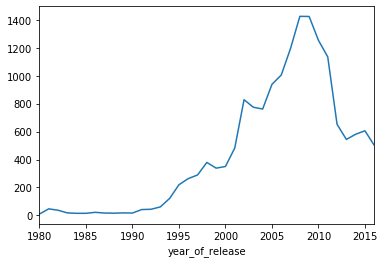

In [122]:
df.groupby('year_of_release')['name'].count().plot()

Свяше 100 игр в год начали выпускать с 1994.

Для актуализации возможно стоит проанализаировать платформы. Посмотрим продажи по платформам:

In [123]:
df.pivot_table(index = 'platform', values = ['sales_all'], aggfunc = 'sum').sort_values(by='sales_all', ascending=False).reset_index()
# создадим сводную таблицу с данными продаж по платформам

,platform,sales_all
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Для анализа лучше будет взять первые 5 платформ лидеров, построим график продаж по годам по каждой:

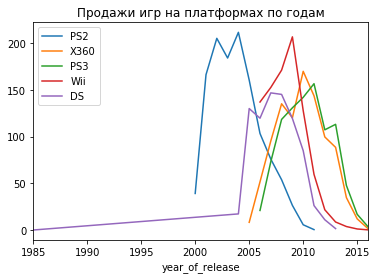

In [124]:
for platform in ['PS2', 'X360', 'PS3', 'Wii', 'DS']:
    df[df['platform'] == platform].groupby('year_of_release')['sales_all'].sum().plot(label=platform)
plt.legend()
plt.title('Продажи игр на платформах по годам')
plt.show()

На графике видно, что в среднем пиковые продажи наблюдатся со второго года жизни по пятый, так же что срок жизни одной платформы 10 лет. Для того чтобы проанализировать когда одно поколение сменяет другое построим график для семейства платформ Playstation:

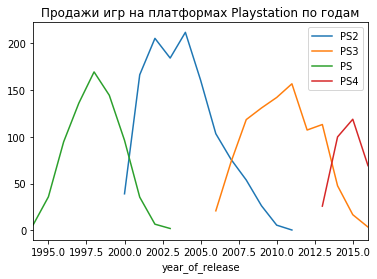

In [125]:
for platform in ['PS2', 'PS3', 'PS', 'PS4']:
    df[df['platform'] == platform].groupby('year_of_release')['sales_all'].sum().plot(label=platform)
plt.legend()
plt.title('Продажи игр на платформах Playstation по годам')
plt.show()

Судя по графику одно поколение сменяет другое примерно каждые 6 лет. 

По итогам анализа считаю, что актуальными являются данные за последние 3 года, так как будет учтено текущее поколение консолей PS4 и XOne, которые судя по графику вышли в 2013 году, это позволит нам учесть максимально актуальные данные.

In [126]:
df = df.query('year_of_release >= 2013')

Данные актуализированы.

### Анализ актуальных платформ

Выберим платформы для анализа по прадажам игр.

In [127]:
df.pivot_table(index = 'platform', values = ['sales_all'], aggfunc = 'sum').sort_values(by='sales_all', ascending=False).reset_index()

,platform,sales_all
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.80
5,WiiU,64.63
6,PC,39.43
7,PSV,32.99
8,Wii,13.66
9,PSP,3.50


Можно определить топ 5 платформ, но следует исключить платформы PS3 и X360, так как это платформы прошлого поколения. В итоге топ-5 выглядит так:
* PS4
* XOne
* 3DS
* WiiU
* PC

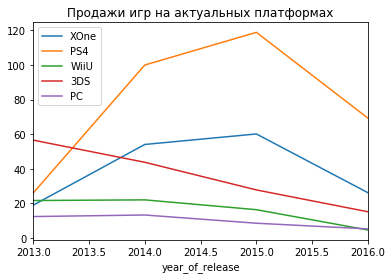

In [128]:
for platform in ['XOne', 'PS4', 'WiiU', '3DS', 'PC']:
    df[df['platform'] == platform].groupby('year_of_release')['sales_all'].sum().plot(label=platform)
plt.legend()
plt.title('Продажи игр на актуальных платформах')
plt.show()

По графику можно заметить, что текущее поколение консолей PS4 и XOne не идут нога в ногу, PS4 опережает по продажам платформу XOne в два раза, это связано с неудачной рекламной компанией и позиционированием своего продукта XOne компанией Microsoft. Хоть продажи 3DS стартовали до начала выбранного периода, но всего лишь за два года, она начала продаваться в феврале 2011, обычно у приставок в этот периода наступает пик продаж, но судя по всему 3DS не удалось обогнать PS4. WiiU похоже была коммерчески не успешной, так как продажи для консоли были очень низкими. Показатели PC достаточно низки, но идут более или менее равномерно, увеличение продаж видно в 2014 году, но дальше идет спад.

### Анализ диапозонов продаж платформ.

Посмотрим в каком диапазоне было больше всего продаж:

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


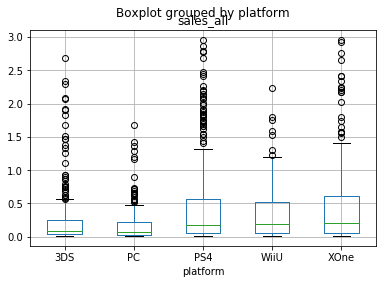

In [129]:
platform = ['XOne', 'PS4', 'WiiU', '3DS', 'PC']
df.query('platform in @platform and sales_all <= 3').boxplot('sales_all', by='platform') 
# построим график ящик с усами по выбранным платформам
# так же ограничим продажи 3 млн копий, чтобы убрать выбросы и укрупнить график для наглядности

Для всех платформ за исключением PC и WiiU медианные значения находятся примерно на одном уровне 0.2-0.3 млн, впрочем как все 4 квартиля. PC имеет такое низкое положение ящика, потому что на платформе нет наценки магазина платформы, так же там больше маленьких игр независимых студий, который менее трудоемки, а значит цена на них ниже. WiiU имеет низкие продажи, возможно они немного выше чем у PC, но это ужасный показатель для консоли, так как внутренний магазин любой консоли закладывает еще наценку в среднем 30%, соответственно, выручка от продаж игр гораздо меньше.

### Анализ оценок пользователей и критиков

Посмотрим как влияют оценки критиков и пользователей на продажи игр на платформах XOne, PS4, WiiU, 3DS, PC предварительно нужно будет убрать значения no score. 

#### PS4

Первой возьмем платформу PS4 и построим диаграмму рассеивания.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


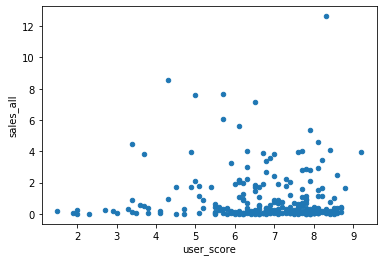

In [130]:
user_score_ps = df.query('platform == "PS4" and user_score != "no score"')
user_score_ps['user_score'] = user_score_ps['user_score'].astype('float')
user_score_ps.plot(x='user_score', y='sales_all', kind='scatter')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


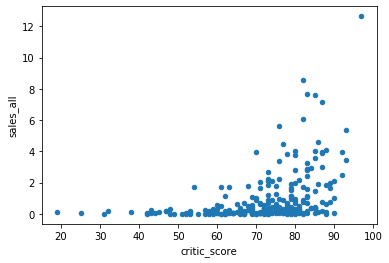

In [131]:
critic_score_ps = df.query('platform == "PS4" and critic_score != "no score"')
critic_score_ps['critic_score'] = critic_score_ps['critic_score'].astype('float')
critic_score_ps.plot(x='critic_score', y='sales_all', kind='scatter')

Так же посчитаем корреляцию:

In [132]:
print('Корреляция user_score и sales_all:', user_score_ps['user_score'].corr(user_score_ps['sales_all']))
print('Корреляция critic_score и sales_all:', critic_score_ps['critic_score'].corr(critic_score_ps['sales_all']))

Корреляция user_score и sales_all: -0.031957110204556376
Корреляция critic_score и sales_all: 0.40656790206178095


Из двух диаграмм можно сделать выводы, что пользовательские оценки более хаотичны, игры оцененные 3-4 баллов могут иметь продажи в 1 и более млн, в то время как у критиков распределение более закономерно и продажи более 1 млн в основном начинаются от оценки свыше 60 баллов, это подтверждает и корреляция, у пользовательского рейтинга она почти равна нулю. Скорее всего это связано с тем, что критик оценивает игру более профессионально, а пользователи скорее эмоционально, поэтому распределение неравномерно. Так же из этих диаграмм можно вынести закономерность, что независимо от оценки большинство игр не продается на общую сумму свыше 1 млн, что совпадает с ранее построенным графиком ящик с усами по всем платформам, большинство игр на всех платформах редко приносит более 1 млн. 

Построим аналогичные диаграммы и посчитаем корреляцию для другой актуальной платформы XOne:

#### XOne

Построим аналогичные диаграммы и посчитаем корреляцию для другой актуальной платформы XOne:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


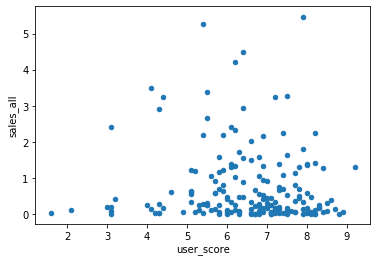

In [133]:
user_score_xbox = df.query('platform == "XOne" and user_score != "no score"')
user_score_xbox['user_score'] = user_score_xbox['user_score'].astype('float')
user_score_xbox.plot(x='user_score', y='sales_all', kind='scatter')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


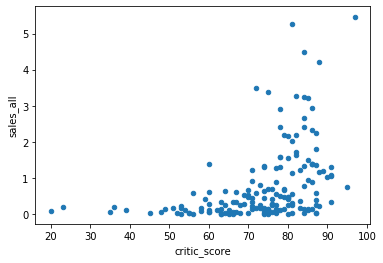

In [134]:
critic_score_xbox = df.query('platform == "XOne" and critic_score != "no score"')
critic_score_xbox['critic_score'] = critic_score_xbox['critic_score'].astype('float')
critic_score_xbox.plot(x='critic_score', y='sales_all', kind='scatter')

In [135]:
print('Корреляция user_score и sales_all:', user_score_xbox['user_score'].corr(user_score_xbox['sales_all']))
print('Корреляция critic_score и sales_all:', critic_score_xbox['critic_score'].corr(critic_score_xbox['sales_all']))

Корреляция user_score и sales_all: -0.06892505328279414
Корреляция critic_score и sales_all: 0.4169983280084017


Результаты схожы с результатами PS4, так же в оценках критиков больше закономерности и корреляциа выше.

#### PC

Посмотрим оценки на PC:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


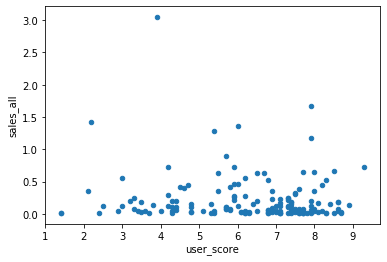

In [136]:
user_score_pc = df.query('platform == "PC" and user_score != "no score"')
user_score_pc['user_score'] = user_score_pc['user_score'].astype('float')
user_score_pc.plot(x='user_score', y='sales_all', kind='scatter')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


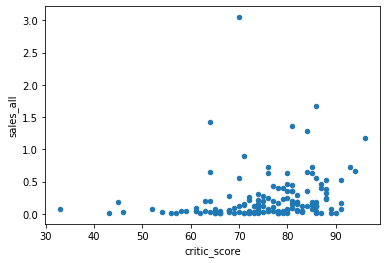

In [137]:
critic_score_pc = df.query('platform == "PC" and critic_score != "no score"')
critic_score_pc['critic_score'] = critic_score_pc['critic_score'].astype('float')
critic_score_pc.plot(x='critic_score', y='sales_all', kind='scatter')

In [138]:
print('Корреляция user_score и sales_all:', user_score_pc['user_score'].corr(user_score_pc['sales_all']))
print('Корреляция critic_score и sales_all:', critic_score_pc['critic_score'].corr(critic_score_pc['sales_all']))

Корреляция user_score и sales_all: -0.0938418695247674
Корреляция critic_score и sales_all: 0.19603028294369382


В целом результаты схоже с тем, что было на других платформах с одним отличаем, корреляция оценок критиков ниже, скорее всего это связано с большим количеством игр от независимых студий, которые хоть и не всегда получаются хорошими в плане качества, но стоят они гораздо дешевле чем продукт крупных издателей, соответственно, купить их может большее количество человек, тем более что платформа есть практически у всех.

#### WiiU

Посмотрим оценки на WiiU:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


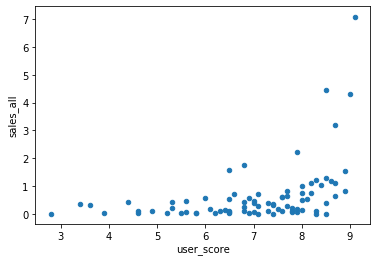

In [139]:
user_score_wiiu = df.query('platform == "WiiU" and user_score != "no score"')
user_score_wiiu['user_score'] = user_score_wiiu['user_score'].astype('float')
user_score_wiiu.plot(x='user_score', y='sales_all', kind='scatter')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


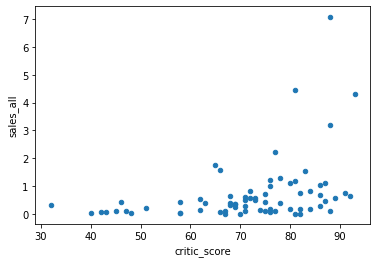

In [140]:
critic_score_wiiu = df.query('platform == "WiiU" and critic_score != "no score"')
critic_score_wiiu['critic_score'] = critic_score_wiiu['critic_score'].astype('float')
critic_score_wiiu.plot(x='critic_score', y='sales_all', kind='scatter')

In [141]:
print('Корреляция user_score и sales_all:', user_score_wiiu['user_score'].corr(user_score_wiiu['sales_all']))
print('Корреляция critic_score и sales_all:', critic_score_wiiu['critic_score'].corr(critic_score_wiiu['sales_all']))

Корреляция user_score и sales_all: 0.4193304819266187
Корреляция critic_score и sales_all: 0.3764149065423912


Похоже, что при низких продажах консоли и игр к ней корреляция и количество положительных оценок возросло, наверно это связано с базой поклонников Nintendo, как правило это люди с большим игровым опытом, возможно поэтому оценки игры получили ближе к оценкам критиков. Возможно это так же связано и с самой Nintendo, так как она старается поддерживать определенную планку качества, ведь по сути консольный рынок такой каким он сейчас является начался именно с того, что Nintendo внедрила контроль качества для игр своей консоли.

#### 3DS

Посмотрим оценки на X360:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


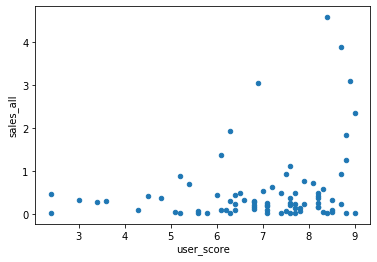

In [142]:
user_score_3ds = df.query('platform == "3DS" and user_score != "no score"')
user_score_3ds['user_score'] = user_score_3ds['user_score'].astype('float')
user_score_3ds.plot(x='user_score', y='sales_all', kind='scatter')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


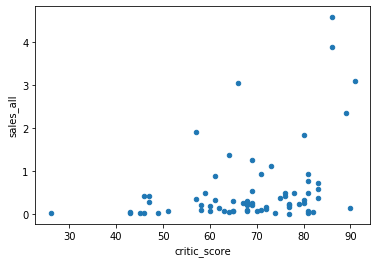

In [143]:
critic_score_3ds = df.query('platform == "3DS" and critic_score != "no score"')
critic_score_3ds['critic_score'] = critic_score_3ds['critic_score'].astype('float')
critic_score_3ds.plot(x='critic_score', y='sales_all', kind='scatter')

In [144]:
print('Корреляция user_score и sales_all:', user_score_3ds['user_score'].corr(user_score_3ds['sales_all']))
print('Корреляция critic_score и sales_all:', critic_score_3ds['critic_score'].corr(critic_score_3ds['sales_all']))

Корреляция user_score и sales_all: 0.24150411773563016
Корреляция critic_score и sales_all: 0.3570566142288103


Данные похожи на WiiU, но все же рейтинг пользователей ощутимо ниже коррелирует с продажами. В любом случае это позволяет предположить, что пользователи консолей Nintendo лучше разбираются в играх, а так же сама компания производитель осуществляет контроль качества.

#### Анализ игр по жанрам

Построим график и посмотрим средние продажи игр по жанрам:

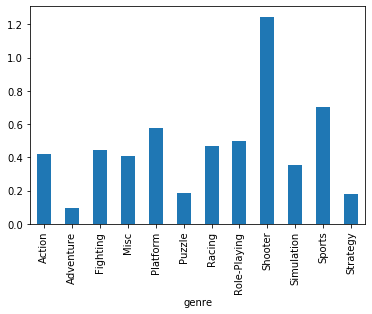

In [145]:
df.groupby('genre')['sales_all'].mean().plot(kind = 'bar')

По графику видно, что три наиболее продаваемых жанра это шутер, спортивные игры и платформер, а три жанра с низкими продажами это стратегия, головоломки и адвенчуры. Платформеры и шутеры является популярными жанрами, так как чаще всего не требуют большего вовлечения пользователя в процесс, а спорт имеет основу спортивных игр, в которые люди играют с детства или смотрят по телевизору, поэтому пользователи зачастую покупают, то что им нравится и что хорошо знакомо. Стратегии и адвенчуры давно в плане развития уперлись в потолок, поэтому игр в данном жанре выходит очень мало, головоломки люди не всегда любят, так как они требуют максимального погружение пользователя в ситуацию, которую поставил перед ним разработчик.

**Вывод**  

Из анализа выше можно определить:
* Основными и актуальными платформами на текущий момент являются PS4 и XOne, так же и PC.
* Больше всего продаж в диапазоне до 0,5 миллиона, опять же выделяется PC. 
* При определении успешности игры лучше всего обращать внимание на рейтинг критиков, так как он ближе всего показывает будут ли высокими продажи или нет. 
* Самые прибыльные жанры платформер, спорт и шутер.

## Портрет пользователей регионов

В это шаге будут исследованы:

* Пользователи региона Северной Америки
* Пользователи региона Европа
* Пользователи региона Япония

### Пользователи региона Северной Америки

Проанализируем предпочтения пользователей по платформам, жанрам и возростным рейтингам:


In [146]:
df.pivot_table(index = ['platform'], values=['na_sales'], aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)


,platform,na_sales
4,PS4,108.74
10,XOne,93.12
9,X360,81.66
3,PS3,63.50
0,3DS,38.20
8,WiiU,29.21
2,PC,11.11
7,Wii,6.56
6,PSV,5.04
1,DS,0.57


In [147]:
df.pivot_table(index = ['genre'], values=['na_sales'], aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)

,genre,na_sales
0,Action,126.05
8,Shooter,109.74
10,Sports,65.27
7,Role-Playing,46.40
3,Misc,27.49
4,Platform,18.14
2,Fighting,15.55
6,Racing,12.96
1,Adventure,7.14
9,Simulation,4.86


In [148]:
df.pivot_table(index = ['rating'], values=['na_sales'], aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)

,rating,na_sales
2,M,165.21
4,not rated,89.42
0,E,79.05
1,E10+,54.24
3,T,49.79


Пользователи Северной Америки предпочитают платформы за исключением не актуальных: PS4, XOne, 3DS, WiiU, PC. Большим спросом среди текущего поколения пользуется PS4, что удивительно, так как США это целевая аудитория компании производителя Microsoft, но PS4 обогнала XOne. WiiU пользовалась здесь большим спросом чем PC. Самые популярные жанры: экшн, спорт, шутер, разное, рпг. Результат не сильно отличается от общей картины по всему миру. Самые популярные рейтинги E, М, Т, Е10+, что интересно есть так же неоцененные игры, их продано примерно 20% от общего количества.

### Пользователи региона Европа

Проанализируем предпочтения пользователей по платформам, жанрам и возростным рейтингам:

In [149]:
df.pivot_table(index = ['platform'], values=['eu_sales'], aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)

,platform,eu_sales
4,PS4,141.09
3,PS3,67.81
10,XOne,51.59
9,X360,42.52
0,3DS,30.96
2,PC,25.36
8,WiiU,19.85
6,PSV,6.10
7,Wii,5.93
1,DS,0.85


In [150]:
df.pivot_table(index = ['genre'], values=['eu_sales'], aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)

,genre,eu_sales
0,Action,118.13
8,Shooter,87.86
10,Sports,60.52
7,Role-Playing,36.97
6,Racing,20.19
3,Misc,20.04
4,Platform,15.58
9,Simulation,10.92
2,Fighting,8.55
1,Adventure,8.25


In [151]:
df.pivot_table(index = ['rating'], values=['eu_sales'], aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)

,rating,eu_sales
2,M,145.32
0,E,83.36
4,not rated,78.91
1,E10+,42.69
3,T,41.95


В Европе наиболее популярны платформы: PS4, XOne, 3DS, WiiU, PC. В целом результат схож с Северной Америкой, за исключением того что WiiU здесь уступило PC. Самые популярные жанры: экшн, спорт, шутер, разное, гонки. В целом данные схожи с общемировыми, гонки обогнали разное на 150 тыс копий, но разница не существенна. Самые популярные рейтинги E, М, Т, Е10+, не оцененных игр в этом регионе продано в общем соотношении так же как и в америке, но все они уступили свои позиции играм с рейтингом E.

### Пользователи региона Япония

Проанализируем предпочтения пользователей по платформам, жанрам и возростным рейтингам:

In [152]:
df.pivot_table(index = ['platform'], values=['jp_sales'], aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)

,platform,jp_sales
0,3DS,67.81
3,PS3,23.35
6,PSV,18.59
4,PS4,15.96
8,WiiU,10.88
5,PSP,3.29
9,X360,0.51
10,XOne,0.34
7,Wii,0.05
1,DS,0.00


In [153]:
df.pivot_table(index = ['genre'], values=['jp_sales'], aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)

,genre,jp_sales
7,Role-Playing,51.04
0,Action,40.49
3,Misc,9.20
2,Fighting,7.65
8,Shooter,6.61
1,Adventure,5.82
10,Sports,5.41
4,Platform,4.79
9,Simulation,4.52
6,Racing,2.30


In [154]:
df.pivot_table(index = ['rating'], values=['jp_sales'], aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)

,rating,jp_sales
4,not rated,85.05
3,T,20.59
0,E,15.14
2,M,14.11
1,E10+,5.89


В Японии наиболее популярны платформы: 3DS, PS4, WiiU, XOne, PC.  Наибольшей популярностью здесь пользуются консоли местных брендов Sony и Nintendo, так как местное население является целевой аудиторией, но что выделяет местный регион среди остальных это то что продажи игр на 3DS превосходят продажи своего ближайшего конкурента текущего поколения в 4 раза, портативные консоли судя по всему очень популярны в этой стране, так как и попавшие из предыдущих поколений PSP и PSV тоже попали в рейтинг, хоть мы их и не учитываем. Самые популярные жанры: рпг, экшн, разное, файтинги, шутеры. Судя по предпочтениям Япония особый рынок со своей игровой культурой, соответственно, и популярность жанров распределена по-другому. Самый популярный рейтинг это отсутствующий, скорее всего местные игроки предпочитают игры произведенные в их стране, которые не оценены международным рейтингом, что неудивительно ведь практически все игры произведенные в Японии не выходят за пределы страны от части из за язкового барьера, поэтому и не получают рейтинг.

**Вывод** В целом рынок Европы не сильно отличается от рынка Северной Америки, по выбору платформ они идентичны, предпочтения в жанрах так же схожи, единственное европейцы предпочитают гонки, хоть и отрыв  от жанра разное не велик. Япония это особенный рынок, по части платформ и жанров они сильно отличаются от других, к примеру самой популярной платформой оказалась 3DS в отличие от PS4 в других регионах. Так же они предпочитают игры, которые произведены в их стране. При выборе стратегии выдачи игр в рекламе для разных регионов следует учесть выше указанные данные.

## Проверка гипотез

Выдвинем гипотезы:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action и Sports разные.

На основе этих гипотез проведем тесты.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Введем нулевую гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, а альтернативную, что средние пользовательские рейтинги платформ Xbox One и PC разные. Выборки для тестов уже были подготовлены, поэтому можно проверить сразу дисперсии обоих тестом Левена:

In [155]:
stat, p = levene(user_score_pc['user_score'], user_score_xbox['user_score'])
p

0.003897553110130418

Показатель ниже 0.05, поэтому считаем выборки неоднородными и указываем в дальнейшем тесте equal_var = False. Далее проверим гипотезу, отбросим в том случае если результат будет меньше 5%.

In [161]:
alpha = .05
result_first = st.ttest_ind(user_score_pc['user_score'], user_score_xbox['user_score'], equal_var=False)

print('p-значение: ', result_first.pvalue)

if result_first.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


По результату теста принимаем нулевую гипотезу, которая гласит: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Введем нулевую гипотезу, что cредние пользовательские рейтинги жанров Action и Sports одинаковые, а альтернативную, что средние пользовательские рейтинги жанров Action и Sports разные. Подготовим выборки для тестов:


In [158]:
action_games_users = df.query('genre == "Action" and user_score != "no score"')
sports_games_users = df.query('genre == "Sports" and user_score != "no score"')

Проверим дисперсии обоих выборок тестом Левена:

In [162]:
stat, p = levene(action_games_users['user_score'], sports_games_users['user_score'])
print('{:0.9f}'.format(p))

4.2566688218274047e-07

Показатель ниже 0.05, поэтому считаем выборки неоднородными и указываем в дальнейшем тесте equal_var = False. Далее проверим гипотезу, отбросим в том случае если результат будет меньше 5%.

In [160]:
alpha = .05
result_first = st.ttest_ind(action_games_users['user_score'], sports_games_users['user_score'], equal_var=False)

print('p-значение: ', '{:0.9f}'.format(result_first.pvalue))

if result_first.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.000000000
Отвергаем нулевую гипотезу


По результату теста отвергаем нулевую гипотезу и принимаем альтернативную, которая гласит, что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Из анализа можно определить, что основными критериями определяющими продажи игры являются оценки критиков и выбранная платформа. Самыми прибыльными платформами являются платформы Sony, и абсолютным лидером на текущий момент является платформа PS4, самые продаваемые проекты сейчас на ней. Оценки критиков, которые чаще указывают на продоваемый продукт находятся выше 60 баллов. Самые популярные жанры платформер, спорт, шутер. Чаще всего игры не продаются тиражем более 0.5 млн копий. На продажи игр так же влияет выбор рынка, в случае с Северной Америкой и Европой критерии почти схожи, в целом их можно рассматривать как идентичный рынок, но в Японии преобладает платформа 3DS, и при этом выбор жанров кардинально отличается. Топ 5 жанров по регионам:

* Северная Америка: экшн, спорт, шутер, разное, рпг;
* Европа: экшн, спорт, шутер, разное, гонки;
* Япония: рпг, экшн, разное, файтинги, шутеры.

Так же в результате проверки были приняты следующие гипотезы, которые можно принять к рассмотрению:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Cредние пользовательские рейтинги жанров Action и Sports разные.

Эти данные необходимо учесть для того, чтобы понимать какие жанры предлагать покупателям в выдаче.